<a href="https://colab.research.google.com/github/clementsiegrist/segmentation_probabilisticDL/blob/main/unet_bayesiannet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
pip install keras opencv-python tensorflow scikit-learn scikit-image numpy pillow matplotlib imutils

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/sandialabs/bcnn

Cloning into 'bcnn'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 117 (delta 63), reused 67 (delta 31), pack-reused 0
Receiving objects: 100% (117/117), 743.27 KiB | 11.99 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [6]:
!pip install tensorflow-gpu==1.12.0 tensorflow-probability==0.5.0 matplotlib==3.1.0 colorcet==2.0.1 brokenaxes==0.3.1 sacred==0.7.5 pymongo==3.8.0

     |████████████████████████████████| 281.7MB 56kB/s 
     |████████████████████████████████| 686kB 54.7MB/s 
     |████████████████████████████████| 13.1MB 259kB/s 
     |████████████████████████████████| 1.6MB 54.8MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 419kB 54.4MB/s 
     |████████████████████████████████| 3.1MB 46.8MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
  Created wheel for brokenaxes: filename=brokenaxes-0.3.1-cp36-none-any.whl size=4846 sha256=55b8705c49bfb5f09e7fa919ec28e50867310e04e5e552ecfdb423fbefe889de
  Stored in directory: /root/.cache/pip/wheels/46/df/12/5b119337c272bbeda8483d0ada967f95f17e214fffc8f5134d
  Created wheel for jsonpickle: filename=jsonpickle-0.9.6-cp36-none-any.whl size=29464 sha256=cc901cd4ebe0e78ada80a4e1308a0d7e630cf0dc9b96cfa9c0e2036b3cc5b03c
  Stored in directo

In [5]:
%cd /content/bcnn/

/content/bcnn


In [8]:
! ls

bayesian_unet.py  dropout_unet.py	LICENSE    requirements.txt   train.py
bayesian_vnet.py  dropout_vnet.py	model.py   stats.py	      unc.PNG
configs		  generate_toy_data.py	pavpu.py   test.py	      utils.py
dataset.py	  groupnorm.py		README.md  toy_train_test.sh


In [23]:
import skimage.io
import numpy as np
path = '/content/drive/MyDrive/Colab Notebooks/cells/test/masks/*0.png'
img_ = skimage.io.imread(path)
print(np.unique(img_))

[  0 255]


In [123]:
import os
path = '/content/weights/bayesian'
for i in os.listdir(path):
  os.remove(os.path.join(path, i))

In [49]:
!python train.py with configs/toy_config.json "num_gpus"=1 "batch_size"=8 "prior_std"=4.5

WARNING - utils - No observers have been added to this run
INFO - utils - Running command 'train'
INFO - utils - Started
loading data...
in save_train_data
getting model...
input shape is (256, 1, 256)
train shape is (502, 256, 1, 256)
val shape is (100, 256, 1, 256)
train_targets shape is (128512, 256, 1)
val_targets shape is (25600, 256, 1)
input shape is (256, 256, 1)
train shape is (502, 256, 256, 1)
val shape is (100, 256, 256, 1)
train_targets shape is (502, 256, 256, 1)
val_targets shape is (100, 256, 256, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
WARNING - tensorflow - From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use 

In [24]:
import skimage
import matplotlib.pyplot as plt
#### Try on Damaé médical Images ####


In [45]:
%matplotlib inline
!python test.py with configs/toy_config.json 

WARNING - utils - No observers have been added to this run
INFO - utils - Running command 'test'
INFO - utils - Started
in save_test_data
input shape  (256, 1, 256)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
WARNING - tensorflow - From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
WARNING - tensorflow - From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py:4277: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule

In [15]:
path = "/content/drive/MyDrive/Colab Notebooks/cells/validation/images"
for i in os.listdir(path):
  if i == '.DS_Store':
    os.remove(os.path.join(path, i))

NameError: ignored

In [7]:
!pip install tensorflow-probability==0.7.0 matplotlib==3.1.0 colorcet==2.0.1 brokenaxes==0.3.1 sacred==0.7.5 pymongo==3.8.0

     |████████████████████████████████| 983kB 15.7MB/s 
     |████████████████████████████████| 13.1MB 229kB/s 
     |████████████████████████████████| 1.6MB 55.3MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 419kB 54.0MB/s 
     |████████████████████████████████| 71kB 12.6MB/s 
     |████████████████████████████████| 102kB 15.5MB/s 
  Created wheel for brokenaxes: filename=brokenaxes-0.3.1-cp36-none-any.whl size=4846 sha256=0cb035e74b98e18c3ee2856c2e9e5791d29b8d82c63acbb4751f3e5cfab4d176
  Stored in directory: /root/.cache/pip/wheels/46/df/12/5b119337c272bbeda8483d0ada967f95f17e214fffc8f5134d
  Created wheel for jsonpickle: filename=jsonpickle-0.9.6-cp36-none-any.whl size=29464 sha256=25cb716121c7bd511b87d3c5f46b32d31d78aba9f9d5a8c922fcf5553b459f22
  Stored in directory: /root/.cache/pip/wheels/07/8b/41/8ce98f4737a9ff61b1bf2673f2abfe66a6a43ad6e91d2c9736
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl si

In [10]:
!sudo apt-get install cuda-9-0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package cuda-9-0


In [8]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 40kB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 3.8MB 52.8MB/s 
     |████████████████████████████████| 512kB 54.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f881758f5ea7863afaef503810dda506a129e19d8db695fb2db7ff6c1688adfa
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Succ

In [ ]:
https://github.com/biomedia-mira/stochastic_segmentation_network **** Données Cerveaux ****
To download the data, go to this page and follow the instructions provided by the challenge's organisers. Run the following script to preprocess the data (input-dir should contain folders HGG and LGG inside):
# python evaluation/preprocessing.py --input-dir <path-to-input-dir> --output-dir <path-to-output-dir>

https://github.com/abhinavsagar/uqvi **** DONNEE CERVAUX ****
Uncertainty Quantification using Variational Inference for Biomedical Image Segmentation
The dataset can be downloaded from here.

https://github.com/sandialabs/bcnn ****** NE DONNE PAS SES DONNEES Mais liobre utilisation ****

#### Cellule ####  Ihab exploite jeu de données cellules / Kaggle 
https://www.kaggle.com/rexhaif/morphological-postprocessing-on-unet-lb-0-429 

# Preprocessing the dataset Kaggle 
https://www.kaggle.com/dingli/keras-u-net-for-nuclei-segmentation 

https://github.com/xiaoketongxue/AI-News/blob/master/CV2019.md 

# sudo apt-get install cuda-9-0

https://github.com/biomedia-mira/stochastic_segmentation_network
To download the data, go to this page and follow the instructions provided by the challenge's organisers. Run the following script to preprocess the data (input-dir should contain folders HGG and LGG inside):
# python evaluation/preprocessing.py --input-dir <path-to-input-dir> --output-dir <path-to-output-dir>

https://github.com/abhinavsagar/uqvi 
Uncertainty Quantification using Variational Inference for Biomedical Image Segmentation
The dataset can be downloaded from here.

In [64]:
#pip install tensorflow==1.15 keras==2.0
!pip install keras==2.4 tensorflow==2.3

     |████████████████████████████████| 174kB 12.4MB/s 
  Using cached https://files.pythonhosted.org/packages/97/ae/0b08f53498417914f2274cc3b5576d2b83179b0cbb209457d0fde0152174/tensorflow-2.3.0-cp36-cp36m-manylinux2010_x86_64.whl
     |████████████████████████████████| 10.6MB 18.3MB/s 
  Using cached https://files.pythonhosted.org/packages/e9/ed/5853ec0ae380cba4588eab1524e18ece1583b65f7ae0e97321f5ff9dfd60/tensorflow_estimator-2.3.0-py2.py3-none-any.whl
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found exist

In [53]:
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import os
import keras
from keras.layers import BatchNormalization, MaxPooling2D, UpSampling2D, Dropout, Conv2D, Dense, Input, Activation, concatenate
#from Models.losses import weighted_bce_dice_loss, weighted_dice_loss
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.utils import class_weight
from keras import layers as L
from keras import backend as K
from keras.models import Model
import tensorflow as tf
import numpy as np
import random
seed = 42
random.seed = seed
np.random.seed(seed=seed)

In [54]:
train_path = "/content/drive/MyDrive/Colab Notebooks/cells/train"
validation_path = "/content/drive/MyDrive/Colab Notebooks/cells/validation"
test_path = "/content/drive/MyDrive/Colab Notebooks/cells/test"
test_batch_size = 4
checkpoint_path = '/content/weights'
input_size = (256, 256) 
target_size = (256, 256) # (height, width) of input_size should be divisible by 32
num_class = 2
# fine tuning
train_batch_size = 4
test_batch_size = 4
validation_batch_size = 4
learning_rate = 1e-4
nb_epochs = 5

In [61]:
def unet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=False, conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder"""
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal')

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def CorneaNet(pretrained_weights=None, input_size=(256, 256, 3)):

    inputs = Input(input_size)
    #weight_ip = L.Input(shape=(256, 512, 1))

    unet_layer1 = unet_layer(inputs, num_filters=16)
    unet_layer1 = unet_layer(unet_layer1, num_filters=16)
    pool1 = MaxPooling2D(pool_size=(2, 2))(unet_layer1)

    unet_layer2 = unet_layer(pool1, num_filters=32)
    unet_layer2 = unet_layer(unet_layer2, num_filters=32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(unet_layer2)

    unet_layer3 = unet_layer(pool2, num_filters=64)
    unet_layer3 = unet_layer(unet_layer3, num_filters=64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(unet_layer3)

    unet_layer4 = unet_layer(pool3, num_filters=128)
    unet_layer4 = unet_layer(unet_layer4, num_filters=128)
    pool4 = MaxPooling2D(pool_size=(2, 2))(unet_layer4)

    unet_layer5 = unet_layer(pool4, num_filters=256)
    unet_layer5 = unet_layer(unet_layer5, num_filters=256)
    drop5 = Dropout(0.5, trainable=True)(unet_layer5)

    up6 = UpSampling2D(size=(2, 2))(drop5)
    unet_layer_after_up6 = unet_layer(up6, num_filters=128)
    merge6 = concatenate([unet_layer4, unet_layer_after_up6])
    unet_layer6 = unet_layer(merge6, num_filters=128)
    unet_layer6 = unet_layer(unet_layer6, num_filters=128)

    up7 = UpSampling2D(size=(2, 2))(unet_layer6)
    unet_layer_after_up7 = unet_layer(up7, num_filters=64)
    merge7 = concatenate([unet_layer3, unet_layer_after_up7])
    unet_layer7 = unet_layer(merge7, num_filters=64)
    unet_layer7 = unet_layer(unet_layer7, num_filters=64)

    up8 = UpSampling2D(size=(2, 2))(unet_layer7)
    unet_layer_after_up8 = unet_layer(up8, num_filters=32)
    merge8 = concatenate([unet_layer2, unet_layer_after_up8])
    unet_layer8 = unet_layer(merge8, num_filters=32)
    unet_layer8 = unet_layer(unet_layer8, num_filters=32)

    up9 = UpSampling2D(size=(2, 2))(unet_layer8)
    unet_layer_after_up9 = unet_layer(up9, num_filters=16)
    merge9 = concatenate([unet_layer1, unet_layer_after_up9])
    unet_layer9 = unet_layer(merge9, num_filters=16)
    unet_layer9 = unet_layer(unet_layer9, num_filters=16)
    unet_layer_last9 = unet_layer(unet_layer9, num_filters=16)
    #dense9 = Conv2D(2, 1, activation='softmax')(unet_layer_last9)
    dense9 = Dense(2, activation='sigmoid')(unet_layer_last9)
    model = Model(inputs, dense9)

    #c11 = L.Lambda(lambda x: x / tf.reduce_sum(x, len(x.get_shape()) - 1, True))(dense9)
    #c11 = L.Lambda(lambda x: tf.clip_by_value(x, epsilon, 1. - epsilon))(c11)
    #c11 = L.Lambda(lambda x: K.log(x))(c11)
    #weighted_sm = L.multiply([c11, weight_ip])
    #model = Model(inputs=[inputs, weight_ip], outputs=[weighted_sm])

    # model = Model(inputs=inputs, outputs=dense9)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [85]:
def generator_adjusted(generator, num_class):

    for (img, mask) in generator:
        img, mask = adjust_data(img, mask, num_class)
        yield img, mask

def train_val_gen(train_path, train_batch_size, validation_path, validation_batch_size):
    '''

    :param train_path:
    :param train_batch_size:
    :param validation_path:
    :param validation_batch_size:
    :return:
    '''
    # generator for training images
    train_image_data_gen_args = dict(rescale=1. / 255)  # transformations
    train_image_datagen = ImageDataGenerator(**train_image_data_gen_args)
    train_image_generator = train_image_datagen.flow_from_directory(train_path, classes=['images'], class_mode=None,  # no labels are returned
                                                                    color_mode='rgb', target_size=input_size,
                                                                    batch_size=train_batch_size, save_to_dir=None, save_prefix='image',
                                                                    seed=1)

    # generator for training masks
    train_mask_data_gen_args = dict()  # transformations
    train_mask_datagen = ImageDataGenerator(**train_mask_data_gen_args)
    train_mask_generator = train_mask_datagen.flow_from_directory(train_path,
                                                                  classes=['masks'], class_mode=None,  # no labels are returned
                                                                  color_mode='grayscale', target_size=input_size,
                                                                  batch_size=train_batch_size, save_to_dir=None, save_prefix='mask',
                                                                  seed=1)

    # generator for validation images
    validation_image_data_gen_args = dict(rescale=1. / 255)  # transformations
    validation_image_datagen = ImageDataGenerator(**validation_image_data_gen_args)
    validation_image_generator = validation_image_datagen.flow_from_directory(validation_path, classes=['images'], class_mode=None,  # no labels are returned
                                                                              color_mode='rgb', target_size=input_size,
                                                                              batch_size=validation_batch_size, save_to_dir=None, save_prefix='image',
                                                                              seed=1)

    # generator for validation masks
    validation_mask_data_gen_args = dict()  # transformations
    validation_mask_datagen = ImageDataGenerator(**validation_mask_data_gen_args)
    validation_mask_generator = validation_mask_datagen.flow_from_directory(validation_path,
                                                                            classes=['masks'], class_mode=None,  # no labels are returned
                                                                            color_mode='grayscale', target_size=input_size,
                                                                            batch_size=validation_batch_size, save_to_dir=None, save_prefix='mask',
                                                                            seed=1)

    # generator for training (image, mask)
    train_generator = zip(train_image_generator, train_mask_generator)
    train_generator = generator_adjusted(train_generator, num_class)  # modify the masks to be one-hot encoded

    # generator for training (image, mask)
    validation_generator = zip(validation_image_generator, validation_mask_generator)
    validation_generator = generator_adjusted(validation_generator, num_class)  # modify the masks to be one-hot encoded

    return train_generator, validation_generator, train_image_generator, validation_image_generator



def plot_images(train_image_generator, train_mask_generator):
    '''

    :param train_image_generator:
    :param train_mask_generator:
    :return:
    '''
    fig1, ax1 = plt.subplots(10, 10)
    fig2, ax2 = plt.subplots(10, 10)
    for i, (img, mask) in enumerate(zip(train_image_generator, train_mask_generator)):
        if i+1 > 100:
            break
        ax1.ravel()[i].imshow(img[:, :, :, 0], 'gray') # [0, :, :, 0]
        ax1.ravel()[i].axis('off')
        ax2.ravel()[i].imshow(mask[:, :, :, 0], 'gray')
        ax2.ravel()[i].axis('off')
        plt.show()


def plot_results(history):
    '''

    :param history:
    :return:
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

# generator for test images
def predict_on_test_and_plot(test_path, model_name):
    '''

    :param test_path:
    :return:
    '''
    class_weight = {0: 3,
                    1: 3.003,
                    2: 1.009}

    test_image_data_gen_args = dict(rescale=1. / 255)  # transformations
    test_image_datagen = ImageDataGenerator(**test_image_data_gen_args)
    test_image_generator = test_image_datagen.flow_from_directory(test_path, classes=['images'], class_mode=None,  # no labels are returned
                                                                  color_mode='rgb', target_size=input_size,
                                                                  batch_size=1, shuffle=False, seed=1)
    # generator for test masks
    test_mask_data_gen_args = dict()  # transformations
    test_mask_datagen = ImageDataGenerator(**test_mask_data_gen_args)
    test_mask_generator = test_mask_datagen.flow_from_directory(test_path,
                                                                classes=['masks'], class_mode=None,  # no labels are returned
                                                                color_mode='grayscale', target_size=input_size,
                                                                batch_size=1, shuffle=False, seed=1)

    #model = load_model(os.path.join(train_path, 'checkpoint', model_name), custom_objects={'lossFunc': WeightedLoss})
    model = load_model(os.path.join('/content/weights', 'checkpoint', model_name), compile=False)
    #model.compile(optimizer=Adam(lr=learning_rate),
    #              loss=weightedLoss(keras.losses.categorical_crossentropy, class_weight),
    #              metrics=['accuracy'])
    
    num_valid = test_image_generator.samples - 90
    results = model.predict_generator(test_image_generator, num_valid, verbose=1)
    results = np.argmax(results, axis=3)

    '''
    model = unet(num_class, input_size=input_size)
    model.load_weights(os.path.join(train_path, 'checkpoint', 'unet_segmentation_epiderm.hdf5'))
    num_valid = test_image_generator.samples
    results = model.predict_generator(test_image_generator, num_valid, verbose=1)
    results = np.argmax(results, axis=3)
    '''

    # Display result
    fig1, ax1 = plt.subplots(num_valid, figsize=(15,15), constrained_layout=True)
    fig2, ax2 = plt.subplots(num_valid, figsize=(15,15), constrained_layout=True)
    #for i in range(5):
        #img, mask = next(zip(test_image_generator, test_mask_generator))
    for i, (img, mask) in enumerate(zip(test_image_generator, test_mask_generator)):
          if i >= num_valid:
            break
          print('iiii', i)
          ax1[i].imshow(img[0,:,:,:])  # original
          ax1[i].axis('off')
          ax2[i].imshow(img[0,:,:,:], 'gray')  # original
          ax2[i].contour(mask[0, :, :, 0], colors='c', linewidths=0.5)
          ax2[i].contour(results[i].astype('float'), colors='r', linewidths=0.5)
          ax2[i].axis('off')
        
          

    plt.show()

In [66]:
def load_pretrained(checkpoint_path, train_generator, validation_generator, validation_batch_size, train_batch_size, nb_epochs,
                    train_image_generator, validation_image_generator):
    
    model = CorneaNet(pretrained_weights=None, input_size=(256, 256, 3))
    #pretrained_weights = os.path.join(train_path, 'checkpoint', 'unet_segmentation_epiderm.hdf5')
    #model.load_weights(pretrained_weights)
    model.summary()
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model_checkpoint = ModelCheckpoint(
        os.path.join(checkpoint_path, 'checkpoint', 'cell_seg.hdf5'),
        monitor='loss',
        verbose=1,
        save_best_only=True)
    rlr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8, patience=5, verbose=1, mode='max')

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=train_image_generator.samples // train_batch_size,
                                  epochs=nb_epochs,
                                  validation_data=validation_generator,
                                  validation_steps=validation_image_generator.samples // validation_batch_size,
                                  callbacks=[model_checkpoint, rlr])
    return history


def main(train_path, train_batch_size, validation_path, validation_batch_size, nb_epochs): #, test_path): #model_name):
    
    model_name = 'cell_seg.hdf5'
    train_generator, validation_generator, train_image_generator, validation_image_generator = train_val_gen(train_path, train_batch_size, validation_path, validation_batch_size)
    model = load_pretrained(checkpoint_path, train_generator, validation_generator, validation_batch_size, train_batch_size, nb_epochs, train_image_generator, validation_image_generator)
    #model = load_unet(train_path, train_generator, validation_generator, validation_batch_size, train_batch_size, nb_epochs, train_image_generator, validation_image_generator)
    #model = Unet_backbone(train_generator, train_image_generator, validation_generator, validation_image_generator, train_batch_size, validation_batch_size, nb_epochs)
    #model = load_weight_map_unet(train_path, train_generator, validation_generator, validation_batch_size, train_batch_size, nb_epochs, train_image_generator, validation_image_generator)
    plot_results(model)
    predict_on_test_and_plot(model_name=model_name, test_path=test_path)
    return model

In [77]:
def adjust_data(img, mask, num_class):
    # modify the masks to be one-hot encoded
    mask = mask[:, :, :, 0] if(len(mask.shape) == 4) else mask[:, :, 0]
    new_mask = np.zeros(mask.shape + (num_class,), dtype=np.uint8)
    for i in range(num_class):
        new_mask[mask == i, i] = 1
    mask = new_mask
    return img, mask

model_name = 'cell_seg.hdf5'
model = main(train_path, train_batch_size, validation_path, validation_batch_size, nb_epochs)
predict_on_test_and_plot(test_path, model_name=model_name)

Found 502 images belonging to 1 classes.
Found 502 images belonging to 1 classes.
Found 68 images belonging to 1 classes.
Found 68 images belonging to 1 classes.
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_437 (Conv2D)             (None, 256, 256, 16) 448         input_20[0][0]                   
__________________________________________________________________________________________________
activation_437 (Activation)     (None, 256, 256, 16) 0           conv2d_437[0][0]                 
__________________________________________________________________________________________________
conv2d_438 (Conv2D)          

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  `Model.evaluate` now supports generators, so there is no longer any need


 19/125 [===>..........................] - ETA: 5s - loss: 0.6638 - accuracy: 0.6949

KeyboardInterrupt: ignored

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7f11b5f5c048>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7f11b5f5c048>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  sub_layers=self._layers,


10/10 [==============================] - 0s 9ms/step
iiii 0
iiii 1
iiii 2
iiii 3
iiii 4
iiii 5
iiii 6
iiii 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:159: UserWarning: No contour levels were found within the data range.


iiii 8
iiii 9


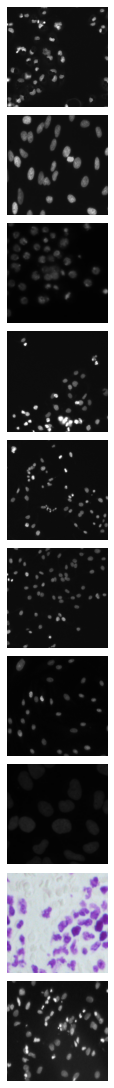

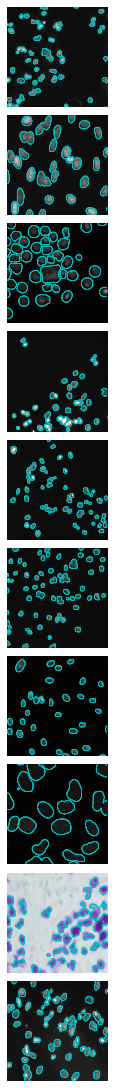

In [86]:
predict_on_test_and_plot(test_path, model_name=model_name)